# EDA Placeholder

EDA done on `Train.csv` from the Customer Segmentation Dataset - Kaggle link [here](https://www.kaggle.com/datasets/vetrirah/customer?resource=download&select=Train.csv)

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from typing import List, Optional, Dict, Tuple, Union

from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

from xgboost import XGBClassifier


In [236]:
data_path = os.path.join("..", "data", "Train.csv")
df = pd.read_csv(data_path)
df.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [237]:
df.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [238]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values", f" | Missing values: {df[col].isnull().sum()}")

ID: 8068 unique values  | Missing values: 0
Gender: 2 unique values  | Missing values: 0
Ever_Married: 2 unique values  | Missing values: 140
Age: 67 unique values  | Missing values: 0
Graduated: 2 unique values  | Missing values: 78
Profession: 9 unique values  | Missing values: 124
Work_Experience: 15 unique values  | Missing values: 829
Spending_Score: 3 unique values  | Missing values: 0
Family_Size: 9 unique values  | Missing values: 335
Var_1: 7 unique values  | Missing values: 76
Segmentation: 4 unique values  | Missing values: 0


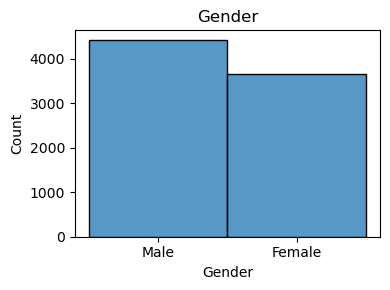

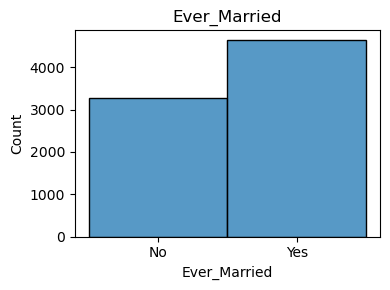

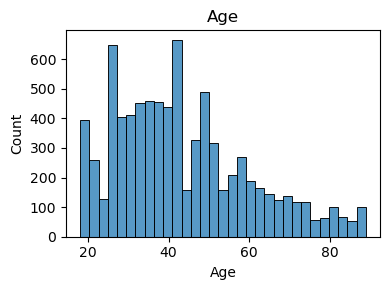

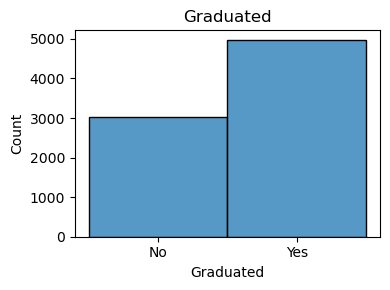

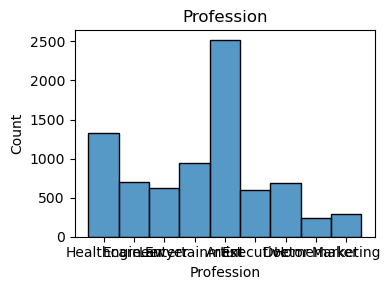

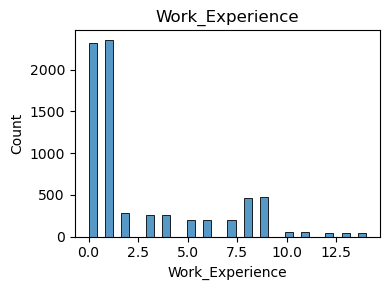

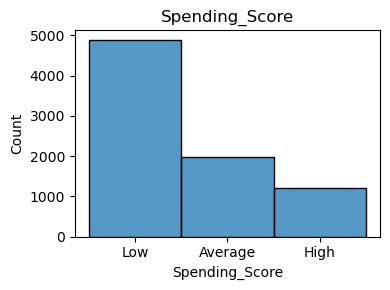

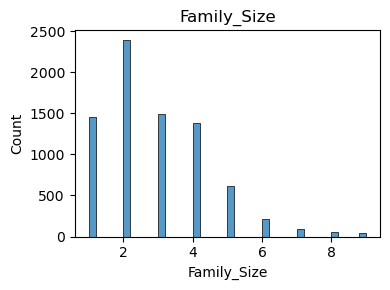

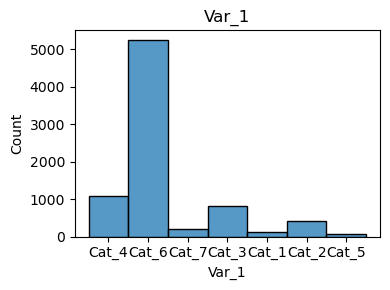

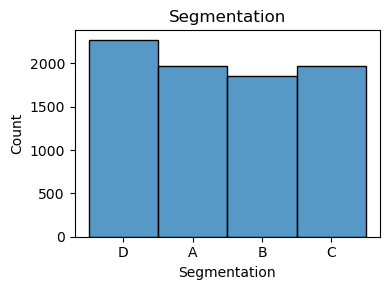

In [239]:
%matplotlib inline

for col in df.columns:
    if col == "ID":
        continue
    plt.figure(figsize=(4,3))
    sns.histplot(data=df, x=col)

    plt.title(col)
    plt.tight_layout()
    plt.show()    

No obvious class imbalance

#### Feature Importance

For preliminary analysis, missing rows are dropped. Eventually the notebook will build a more rigorous preprocessing pipeline to handle missing values according to the data type.

In [212]:
X = df.drop(columns=['Segmentation'])
y = df['Segmentation']

# Encode non-numeric columns
X_encoded = X.copy()
for col in X_encoded.columns:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Replace missing with -1 (mutual_info_classif can't handle NaN)
X_encoded = X_encoded.fillna(-1)

mi = mutual_info_classif(X_encoded, y, discrete_features='auto')

mi_scores = pd.Series(mi, index=X_encoded.columns).sort_values(ascending=False)

for col, score in mi_scores.items():
    print(f"{col:20s}: {score:.4f}")

ID                  : 0.1772
Age                 : 0.1757
Profession          : 0.1663
Spending_Score      : 0.1072
Ever_Married        : 0.0862
Graduated           : 0.0608
Family_Size         : 0.0422
Var_1               : 0.0091
Work_Experience     : 0.0020
Gender              : 0.0000


### Train-test split

Performing 80-10-10 Stratified split into train, validation, and test sets.


In [ ]:
X = df.drop("Segmentation", axis=1)
y = df["Segmentation"]

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,       
    stratify=y,
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,       
    stratify=y_temp,
)

print(f"Train length: {len(X_train)}")
print(f"Validation length: {len(X_val)}")
print(f"Test length: {len(X_test)}")

Train length: 6454
Validation length: 807
Test length: 807


#### Preprocessing Functions

In [242]:
BOOL_COLS = ["Gender", "Ever_Married", "Graduated"]
NUM_COLS  = ["Age", "Work_Experience", "Family_Size"]
ORD_COLS  = ["Spending_Score"]                 
CAT_COLS  = ["Profession", "Var_1"]
TARGET    = "Segmentation"


ORD_MAP = {"low": 0, "average": 1, "high": 2}



In [243]:
def _boolean_map(col: pd.Series, yes_no_map: Dict[str, int]) -> pd.Series:
    s = col.astype("string").str.strip().str.lower()
    return s.map(yes_no_map)

In [244]:
def _fit_numeric_stats(X: pd.DataFrame, cols: List[str]) -> Dict[str, Dict[str, float]]:
    stats = {}
    for c in cols:
        # Robust numeric conversion
        s = pd.to_numeric(X[c], errors="coerce")
        if s.dropna().empty:
            # Column is entirely NaN / non-numeric in this split
            stats[c] = {"median": 0.0, "mean": 0.0, "std": 1.0}
        else:
            med = float(s.median())
            mu  = float(s.fillna(med).mean())
            sd  = float(s.fillna(med).std(ddof=0))
            if not np.isfinite(sd) or sd == 0:
                sd = 1.0
            stats[c] = {"median": med, "mean": mu, "std": sd}
    return stats

In [245]:
def _transform_numeric_standardized(X: pd.DataFrame, stats: Dict[str, Dict[str, float]]) -> pd.DataFrame:
    out = pd.DataFrame(index=X.index)
    for c, st in stats.items():
        s = pd.to_numeric(X[c], errors="coerce").fillna(st["median"])
        out[c + "_z"] = (s - st["mean"]) / st["std"]
    return out

In [246]:
def _transform_numeric_imputed(X: pd.DataFrame, stats: Dict[str, Dict[str, float]]) -> pd.DataFrame:
    out = pd.DataFrame(index=X.index)
    for c, st in stats.items():
        s = pd.to_numeric(X[c], errors="coerce").fillna(st["median"])
        out[c] = s
    return out

In [247]:
def _fit_bool_modes(X: pd.DataFrame) -> Dict[str, int]:
    modes = {}
    maps = {
        "Gender": {"male": 1, "female": 0},
        "Ever_Married": {"yes": 1, "no": 0},
        "Graduated": {"yes": 1, "no": 0}
    }
    for c in [col for col in BOOL_COLS if col in X.columns]:
        s = _boolean_map(X[c], maps.get(c, {}))
        modes[c] = int(s.mode(dropna=True).iloc[0]) if s.notna().any() else 0
    return modes

In [248]:
def _transform_booleans(X: pd.DataFrame, modes: Dict[str, int]) -> pd.DataFrame:
    out = pd.DataFrame(index=X.index)
    maps = {
        "Gender": {"male": 1, "female": 0},
        "Ever_Married": {"yes": 1, "no": 0},
        "Graduated": {"yes": 1, "no": 0}
    }
    for c in [col for col in BOOL_COLS if col in X.columns]:
        s = _boolean_map(X[c], maps.get(c, {}))
        out[c] = s.fillna(modes[c]).astype(int)
    return out

In [ ]:
def _transform_ordinal(X: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=X.index)
    if "Spending_Score" in X.columns:
        s = X["Spending_Score"].astype("string").str.strip().str.lower().map(ORD_MAP)
        out["Spending_Score_ordinal"] = s.fillna(-1).astype(int) 
    return out

In [250]:
def _fit_categorical_levels(X: pd.DataFrame, cat_cols: List[str]) -> Dict[str, List[str]]:
    levels = {}
    for c in [col for col in cat_cols if col in X.columns]:
        s = X[c].astype("string").fillna("Missing")
        levels[c] = sorted(s.unique().tolist())
        if "Missing" not in levels[c]:
            levels[c].append("Missing")
    return levels

In [251]:
def _transform_categoricals_onehot(X: pd.DataFrame, levels: Dict[str, List[str]]) -> pd.DataFrame:
    parts = []
    for c, cats in levels.items():
        s = X[c].astype("string").fillna("Missing")
        s = pd.Categorical(s, categories=cats, ordered=False)
        d = pd.get_dummies(s, prefix=c, dtype=int)
        parts.append(d)
    return pd.concat(parts, axis=1) if parts else pd.DataFrame(index=X.index)


In [270]:
def preprocess_logreg_fit(X_train: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    X_train = X_train.copy()
    state: Dict = {}

    state["num_stats"]  = _fit_numeric_stats(X_train, [c for c in NUM_COLS if c in X_train.columns])
    state["bool_modes"] = _fit_bool_modes(X_train)
    state["cat_levels"] = _fit_categorical_levels(X_train, CAT_COLS)

    base_index = X_train.index

    parts = []
    if state["bool_modes"]:
        parts.append(_transform_booleans(X_train, state["bool_modes"]))
    parts.append(_transform_ordinal(X_train))
    if state["cat_levels"]:
        parts.append(_transform_categoricals_onehot(X_train, state["cat_levels"]))
    if state["num_stats"]:
        parts.append(_transform_numeric_standardized(X_train, state["num_stats"]))

    # <<< force identical index on every part
    parts = [p.reindex(base_index) for p in parts if not p.empty]

    Xtr = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=base_index)
    Xtr = Xtr.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    state["columns"] = Xtr.columns.tolist()
    return Xtr, state

In [271]:
def preprocess_logreg_transform(X_any: pd.DataFrame, state: Dict) -> pd.DataFrame:
    X_any = X_any.copy()
    base_index = X_any.index

    parts = []
    if state.get("bool_modes"):
        parts.append(_transform_booleans(X_any, state["bool_modes"]))
    parts.append(_transform_ordinal(X_any))
    if state.get("cat_levels"):
        parts.append(_transform_categoricals_onehot(X_any, state["cat_levels"]))
    if state.get("num_stats"):
        parts.append(_transform_numeric_standardized(X_any, state["num_stats"]))

    parts = [p.reindex(base_index) for p in parts if not p.empty]

    Xout = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=base_index)
    Xout = Xout.reindex(columns=state["columns"], fill_value=0.0)
    Xout = Xout.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return Xout


In [272]:
def preprocess_xgb_fit(X_train: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    X_train = X_train.copy()
    state: Dict = {}

    state["num_stats"]  = _fit_numeric_stats(X_train, [c for c in NUM_COLS if c in X_train.columns])
    state["bool_modes"] = _fit_bool_modes(X_train)
    state["cat_levels"] = _fit_categorical_levels(X_train, CAT_COLS)

    base_index = X_train.index

    parts = []
    if state["bool_modes"]:
        parts.append(_transform_booleans(X_train, state["bool_modes"]))
    parts.append(_transform_ordinal(X_train))
    if state["cat_levels"]:
        parts.append(_transform_categoricals_onehot(X_train, state["cat_levels"]))
    if state["num_stats"]:
        parts.append(_transform_numeric_imputed(X_train, state["num_stats"]))

    parts = [p.reindex(base_index) for p in parts if not p.empty]

    Xtr = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=base_index)
    Xtr = Xtr.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    state["columns"] = Xtr.columns.tolist()
    return Xtr, state


In [273]:
def preprocess_xgb_transform(X_any: pd.DataFrame, state: Dict) -> pd.DataFrame:
    X_any = X_any.copy()
    base_index = X_any.index

    parts = []
    if state.get("bool_modes"):
        parts.append(_transform_booleans(X_any, state["bool_modes"]))
    parts.append(_transform_ordinal(X_any))
    if state.get("cat_levels"):
        parts.append(_transform_categoricals_onehot(X_any, state["cat_levels"]))
    if state.get("num_stats"):
        parts.append(_transform_numeric_imputed(X_any, state["num_stats"]))

    parts = [p.reindex(base_index) for p in parts if not p.empty]

    Xout = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=base_index)
    Xout = Xout.reindex(columns=state["columns"], fill_value=0.0)
    Xout = Xout.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return Xout

In [274]:
def preprocess_pipeline_logreg(
    df: pd.DataFrame,
    state: Optional[Dict] = None
) -> Tuple[pd.DataFrame, Dict]:
    """
    If state is None -> fit on df and return (X, state).
    If state is provided -> transform df using fitted state and return (X, state).
    """
    if state is None:
        return preprocess_logreg_fit(df)
    else:
        return preprocess_logreg_transform(df, state), state

def preprocess_pipeline_xgb(
    df: pd.DataFrame,
    state: Optional[Dict] = None
) -> Tuple[pd.DataFrame, Dict]:
    """
    If state is None -> fit on df and return (X, state).
    If state is provided -> transform df using fitted state and return (X, state).
    """
    if state is None:
        return preprocess_xgb_fit(df)
    else:
        return preprocess_xgb_transform(df, state), state

### Logistic Regression

In [275]:
Xtr_lr, lr_state = preprocess_pipeline_logreg(X_train.copy())          # FIT
Xva_lr, _        = preprocess_pipeline_logreg(X_val.copy(),  lr_state) # TRANSFORM
Xte_lr, _        = preprocess_pipeline_logreg(X_test.copy(), lr_state) # TRANSFORM

In [ ]:
lr_solver = "lbfgs"
lr_penalty = "l2"
lr_max_iter = 1000
lr_multi_class = "multinomial"
lr_random_state = 42
C_values = np.logspace(-3, 2, num=12)


In [ ]:
logreg = LogisticRegression(
    solver=lr_solver,
    penalty=lr_penalty,
    max_iter=lr_max_iter,
    multi_class=lr_multi_class,
    random_state=lr_random_state
)

In [278]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': C_values}

grid_lr = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

In [280]:
grid_lr.fit(Xtr_lr, y_train)
print("LR best params:", grid_lr.best_params_)
print("LR best CV bal.acc:", grid_lr.best_score_)

LR best params: {'C': np.float64(0.008111308307896872)}
LR best CV bal.acc: 0.4345219521713828


d:\AnacondaEnvs\ds-base\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [295]:
cvres = pd.DataFrame(grid_lr.cv_results_)

# Extract useful columns
cvres_plot = cvres[["param_C", "mean_train_score", "mean_test_score", "std_test_score"]].copy()
cvres_plot.rename(columns={
    "param_C": "C",
    "mean_train_score": "Train Balanced Accuracy",
    "mean_test_score": "Validation Balanced Accuracy",
    "std_test_score": "Validation Std"
}, inplace=True)

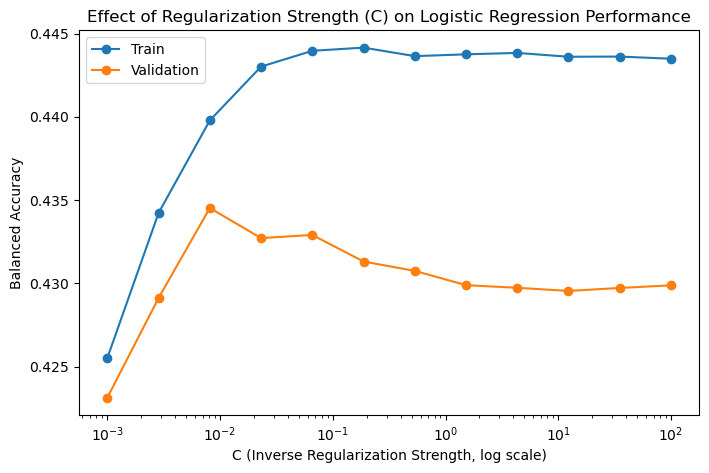

Best C: 0.008111308307896872
Best CV Balanced Accuracy: 0.4345


In [298]:
cvres_plot = cvres_plot.sort_values(by="C")

# Plot
plt.figure(figsize=(8,5))
plt.semilogx(
    cvres_plot["C"],
    cvres_plot["Train Balanced Accuracy"],
    marker="o", label="Train"
)
plt.semilogx(
    cvres_plot["C"],
    cvres_plot["Validation Balanced Accuracy"],
    marker="o", label="Validation"
)

plt.xlabel("C (Inverse Regularization Strength, log scale)")
plt.ylabel("Balanced Accuracy")
plt.title("Effect of Regularization Strength (C) on Logistic Regression Performance")
plt.legend()
plt.show()

# Optional: print best C
print(f"Best C: {grid_lr.best_params_['C']}")
print(f"Best CV Balanced Accuracy: {grid_lr.best_score_:.4f}")

Balanced classes (A–D roughly equal)	So imbalance handling (e.g. class_weight) won’t help.
Accuracy ≈ random chance (0.25 for 4 classes, you got 0.50)	The model is only moderately better than random — signals exist, but the linear boundary of logistic regression is insufficient.
Recall low for some classes (B)	Some classes are overlapping in feature space.
Balanced accuracy < 0.5	Suggests the model is not capturing structure beyond noise.

In [ ]:
y_val_pred_lr = grid_lr.best_estimator_.predict(Xva_lr)
print("\n[LR][VAL] Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("[LR][VAL] Balanced Accuracy:", balanced_accuracy_score(y_val, y_val_pred_lr))
print("\n[LR][VAL] Classification Report:\n", classification_report(y_val, y_val_pred_lr))
print("[LR][VAL] Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_lr))



[LR][VAL] Accuracy: 0.4560099132589839
[LR][VAL] Balanced Accuracy: 0.4403431571627561

[LR][VAL] Classification Report:
               precision    recall  f1-score   support

           A       0.35      0.36      0.35       197
           B       0.24      0.05      0.08       186
           C       0.46      0.64      0.54       197
           D       0.55      0.72      0.62       227

    accuracy                           0.46       807
   macro avg       0.40      0.44      0.40       807
weighted avg       0.41      0.46      0.41       807

[LR][VAL] Confusion Matrix:
 [[ 70  12  47  68]
 [ 59   9  80  38]
 [ 31  11 126  29]
 [ 40   5  19 163]]


In [300]:
Xtrval_lr = pd.concat([Xtr_lr, Xva_lr], axis=0)
y_trval    = pd.concat([y_train, y_val], axis=0)

final_logreg = LogisticRegression(
    solver=lr_solver,
    penalty=lr_penalty,
    C=grid_lr.best_params_['C'],
    max_iter=lr_max_iter,
    multi_class=lr_multi_class,
    random_state=lr_random_state
).fit(Xtrval_lr, y_trval)



d:\AnacondaEnvs\ds-base\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [301]:
y_test_pred_lr = final_logreg.predict(Xte_lr)
print("\n[LR][TEST] Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("[LR][TEST] Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred_lr))
print("\n[LR][TEST] Classification Report:\n", classification_report(y_test, y_test_pred_lr))
print("[LR][TEST] Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_lr))


[LR][TEST] Accuracy: 0.4882280049566295
[LR][TEST] Balanced Accuracy: 0.47212885745083943

[LR][TEST] Classification Report:
               precision    recall  f1-score   support

           A       0.38      0.34      0.36       197
           B       0.41      0.07      0.12       186
           C       0.47      0.72      0.57       197
           D       0.58      0.76      0.66       227

    accuracy                           0.49       807
   macro avg       0.46      0.47      0.43       807
weighted avg       0.46      0.49      0.44       807

[LR][TEST] Confusion Matrix:
 [[ 67  11  48  71]
 [ 49  13  94  30]
 [ 27   3 142  25]
 [ 32   5  18 172]]


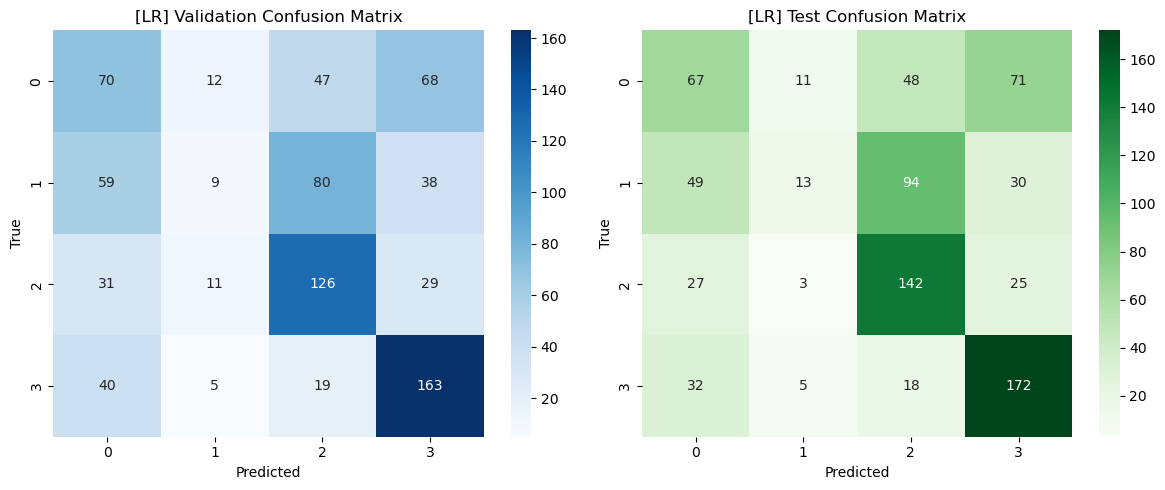

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    confusion_matrix(y_val, y_val_pred_lr),
    annot=True, fmt="d", cmap="Blues", ax=axes[0]
)
axes[0].set_title("[LR] Validation Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    confusion_matrix(y_test, y_test_pred_lr),
    annot=True, fmt="d", cmap="Greens", ax=axes[1]
)
axes[1].set_title("[LR] Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

### XG Boost

XGBoost requires minimal scaling and variable encoding, as it can handle missing values. However requires label encoding to convert class labels to integer indices.

Due to longer training times and a larger pool of hyperparameters, the notebook opted for sequential cross-fold validation, tuning two hyperparameters at a time.

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([y_train, y_val, y_test], axis=0))  
y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
num_classes = len(le.classes_)
print("Label mapping:", dict(zip(le.classes_, range(num_classes))))


Label mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [284]:
Xtr_xgb, xgb_state = preprocess_pipeline_xgb(X_train.copy())           # FIT
Xva_xgb, _         = preprocess_pipeline_xgb(X_val.copy(),  xgb_state) # TRANSFORM
Xte_xgb, _         = preprocess_pipeline_xgb(X_test.copy(), xgb_state) # TRANSFORM

In [ ]:
def plot_cv_heatmap(cvres: pd.DataFrame, x_param: str, y_param: str, title_prefix: str):
    pvt = cvres.pivot_table(index=f"param_{y_param}",
                            columns=f"param_{x_param}",
                            values="mean_test_score")

    plt.figure(figsize=(7,5))
    sns.heatmap(pvt, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"{title_prefix} — CV Accuracy")
    plt.xlabel(x_param); plt.ylabel(y_param)
    plt.tight_layout()
    plt.show()


    pvt_tr = cvres.pivot_table(index=f"param_{y_param}",
                               columns=f"param_{x_param}",
                               values="mean_train_score")

    plt.figure(figsize=(7,5))
    sns.heatmap(pvt_tr, annot=True, fmt=".3f", cmap="magma")
    plt.title(f"{title_prefix} — Train Accuracy")
    plt.xlabel(x_param); plt.ylabel(y_param)
    plt.tight_layout()
    plt.show()

In [304]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)



In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_params = {
    "max_depth": 4,         
    "min_child_weight": 1,
    "learning_rate": 0.05,   
    "n_estimators": 400,
    "subsample": 1.0,        
    "colsample_bytree": 1.0,
    "reg_lambda": 1.0,      
    "reg_alpha": 0.0,
}

In [306]:
param_grid_stage1 = {
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5]
}

xgb_stage1 = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    reg_lambda=best_params["reg_lambda"],
    reg_alpha=best_params["reg_alpha"]
)

grid_xgb_stage1 = GridSearchCV(
    estimator=xgb_stage1,
    param_grid=param_grid_stage1,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)




In [307]:
grid_xgb_stage1.fit(Xtr_xgb, y_train_enc)
print("[XGB][Stage 1] Best params:", grid_xgb_stage1.best_params_)
print("[XGB][Stage 1] Best CV accuracy:", grid_xgb_stage1.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[XGB][Stage 1] Best params: {'max_depth': 3, 'min_child_weight': 5}
[XGB][Stage 1] Best CV accuracy: 0.4879134617116711


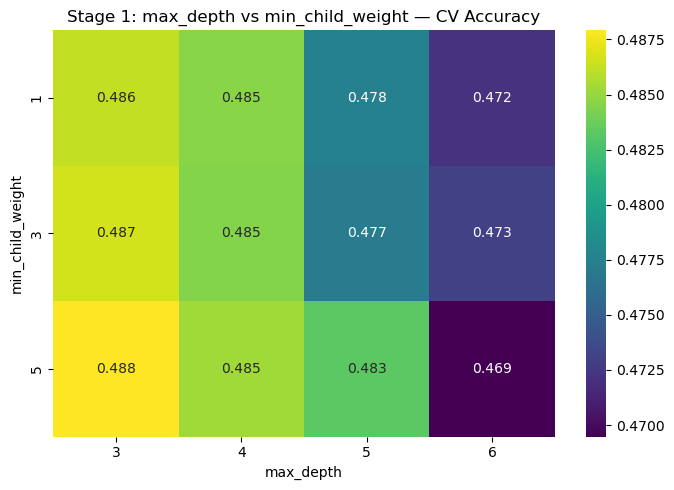

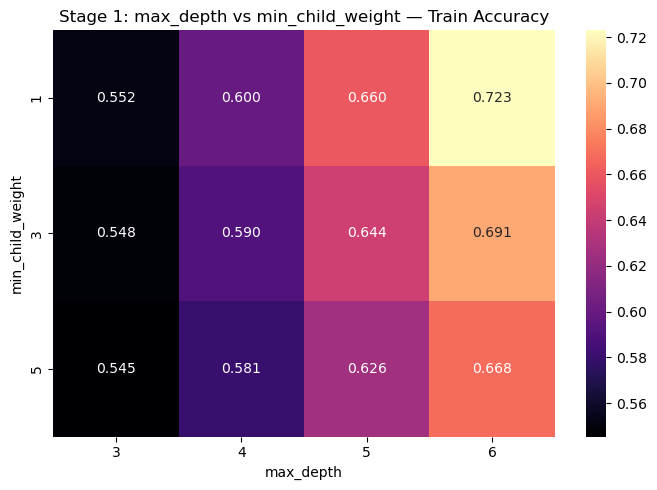

In [ ]:
cvres1 = pd.DataFrame(grid_xgb_stage1.cv_results_)
plot_cv_heatmap(cvres1, x_param="max_depth", y_param="min_child_weight",
                title_prefix="Stage 1: max_depth vs min_child_weight")

best_params.update(grid_xgb_stage1.best_params_)

In [ ]:
param_grid_stage2 = {
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [200, 400, 600]
}

xgb_stage2 = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    reg_lambda=best_params["reg_lambda"],
    reg_alpha=best_params["reg_alpha"]
)

grid_xgb_stage2 = GridSearchCV(
    estimator=xgb_stage2,
    param_grid=param_grid_stage2,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

In [310]:
grid_xgb_stage2.fit(Xtr_xgb, y_train_enc)
print("[XGB][Stage 2] Best params:", grid_xgb_stage2.best_params_)
print("[XGB][Stage 2] Best CV accuracy:", grid_xgb_stage2.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[XGB][Stage 2] Best params: {'learning_rate': 0.03, 'n_estimators': 200}
[XGB][Stage 2] Best CV accuracy: 0.48915269096127634


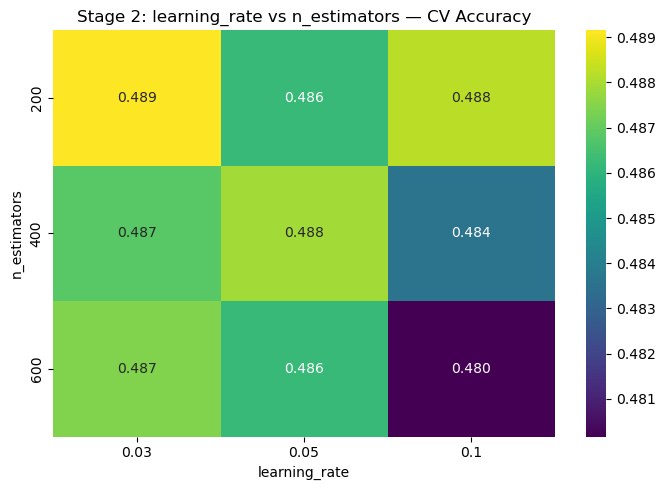

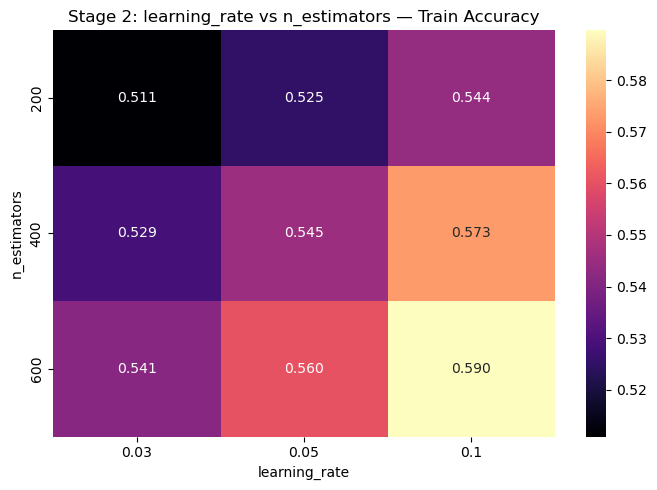

In [ ]:
cvres2 = pd.DataFrame(grid_xgb_stage2.cv_results_)
plot_cv_heatmap(cvres2, x_param="learning_rate", y_param="n_estimators",
                title_prefix="Stage 2: learning_rate vs n_estimators")

best_params.update(grid_xgb_stage2.best_params_)


In [ ]:
param_grid_stage3 = {
    "reg_lambda": [1.0, 2.0, 5.0],
    "reg_alpha": [0.0, 0.5, 1.0]
}

xgb_stage3 = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"]
)
grid_xgb_stage3 = GridSearchCV(
    estimator=xgb_stage3,
    param_grid=param_grid_stage3,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

In [313]:
grid_xgb_stage3.fit(Xtr_xgb, y_train_enc)
print("[XGB][Stage 3] Best params:", grid_xgb_stage3.best_params_)
print("[XGB][Stage 3] Best CV accuracy:", grid_xgb_stage3.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[XGB][Stage 3] Best params: {'reg_alpha': 0.0, 'reg_lambda': 5.0}
[XGB][Stage 3] Best CV accuracy: 0.4911673541933121


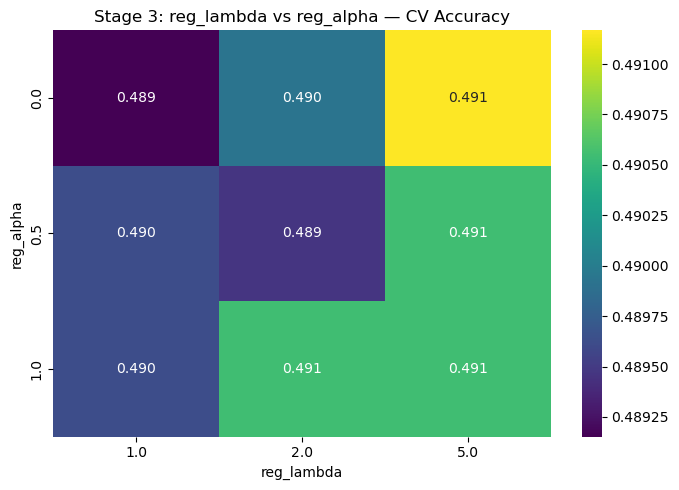

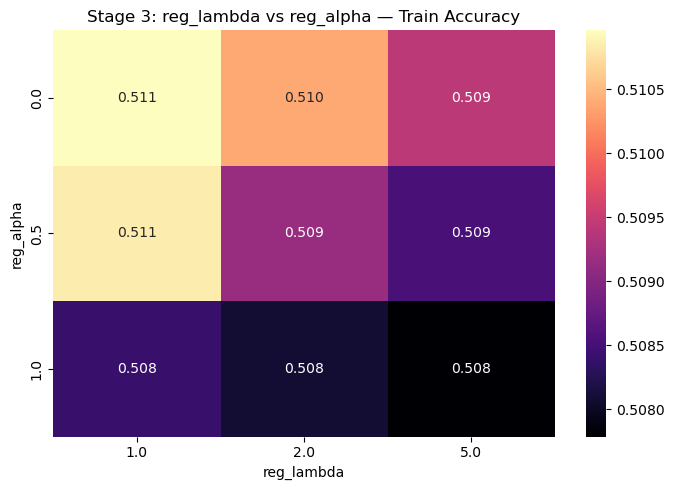

In [ ]:
cvres3 = pd.DataFrame(grid_xgb_stage3.cv_results_)
plot_cv_heatmap(cvres3, x_param="reg_lambda", y_param="reg_alpha",
                title_prefix="Stage 3: reg_lambda vs reg_alpha")

best_params.update(grid_xgb_stage3.best_params_)

In [316]:
print("\n[XGB] Sequential best params (combined):", best_params)

Xtrval_xgb = pd.concat([Xtr_xgb, Xva_xgb], axis=0)
y_trval_enc = np.concatenate([y_train_enc, y_val_enc], axis=0)
final_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    **best_params
).fit(Xtrval_xgb, y_trval_enc)



[XGB] Sequential best params (combined): {'max_depth': 3, 'min_child_weight': 5, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.0}


In [318]:
y_val_pred_enc = final_xgb.predict(Xva_xgb)
y_val_pred = le.inverse_transform(y_val_pred_enc)

print("\n[XGB][VAL] Accuracy:", accuracy_score(y_val, y_val_pred))
print("[XGB][VAL] Balanced Accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("\n[XGB][VAL] Classification Report:\n", classification_report(y_val, y_val_pred))
print("[XGB][VAL] Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))



[XGB][VAL] Accuracy: 0.5117719950433705
[XGB][VAL] Balanced Accuracy: 0.5016257733175886

[XGB][VAL] Classification Report:
               precision    recall  f1-score   support

           A       0.42      0.42      0.42       197
           B       0.39      0.26      0.31       186
           C       0.55      0.64      0.59       197
           D       0.61      0.69      0.65       227

    accuracy                           0.51       807
   macro avg       0.49      0.50      0.49       807
weighted avg       0.50      0.51      0.50       807

[XGB][VAL] Confusion Matrix:
 [[ 82  36  30  49]
 [ 50  49  65  22]
 [ 21  22 126  28]
 [ 43  20   8 156]]


In [319]:

y_test_pred_enc = final_xgb.predict(Xte_xgb)
y_test_pred = le.inverse_transform(y_test_pred_enc)

print("\n[XGB][TEST] Accuracy:", accuracy_score(y_test, y_test_pred))
print("[XGB][TEST] Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("\n[XGB][TEST] Classification Report:\n", classification_report(y_test, y_test_pred))
print("[XGB][TEST] Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



[XGB][TEST] Accuracy: 0.530359355638166
[XGB][TEST] Balanced Accuracy: 0.5202332149597474

[XGB][TEST] Classification Report:
               precision    recall  f1-score   support

           A       0.43      0.41      0.42       197
           B       0.39      0.27      0.32       186
           C       0.56      0.71      0.62       197
           D       0.65      0.70      0.68       227

    accuracy                           0.53       807
   macro avg       0.51      0.52      0.51       807
weighted avg       0.51      0.53      0.52       807

[XGB][TEST] Confusion Matrix:
 [[ 80  44  28  45]
 [ 42  50  74  20]
 [ 14  24 139  20]
 [ 50   9   9 159]]


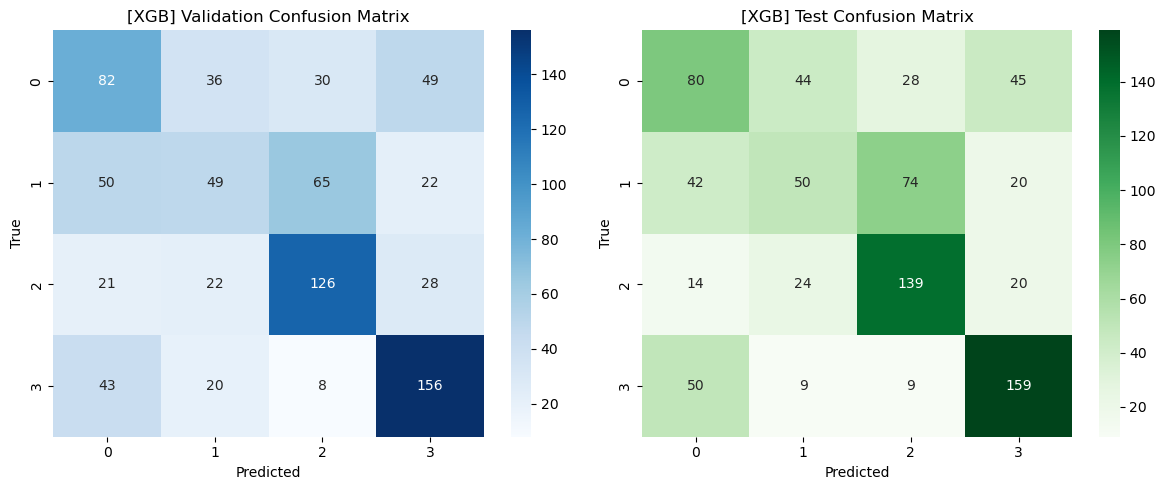

In [320]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred),
            annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("[XGB] Validation Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("[XGB] Test Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()